In [19]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils import data
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import zipfile

%matplotlib inline

In [2]:
base_data_dir = os.path.abspath('../../_data')
kmnist_data_dir = os.path.join(base_data_dir, 'Kannada-MNIST')
kmnist_zip_file = os.path.join(base_data_dir, 'Kannada-MNIST.zip')

### Download the competiotion datasets

In [ ]:
# Downloading dataset
! kaggle competitions download -c Kannada-MNIST -p {base_data_dir}

In [ ]:
# Extract the zip file
with zipfile.ZipFile(file=kmnist_zip_file, mode='r') as z:
    z.extractall(kmnist_data_dir)

In [ ]:
# Delete the zip downloaded file
! rm {kmnist_zip_file}

### Load and investigate the data

In [3]:
! ls {kmnist_data_dir}

Dig-MNIST.csv
sample_submission.csv
test.csv
train.csv


In [4]:
train_csv = pd.read_csv(filepath_or_buffer= kmnist_data_dir + '/train.csv')
test_csv = pd.read_csv(filepath_or_buffer= kmnist_data_dir + '/test.csv')

In [5]:
train_csv.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test_csv.head()

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Images are 28x28 pixels, and pixels are flattend and each image saved in a row (total of 784 pixels)**

In [7]:
# Save values of images in numpy.ndarray
trainset = train_csv.iloc[:, 1:].values
labels = train_csv.iloc[:, 0].values
testset = test_csv.iloc[:, 1:].values

print(f'Train set shape: {trainset.shape}')
print(f'Test set shape: {testset.shape}')

Train set shape: (60000, 784)
Test set shape: (5000, 784)


In [8]:
print(f'Min pixel value: {trainset.min()}')
print(f'Max pixel value: {trainset.max()}')

Min pixel value: 0
Max pixel value: 255


In [9]:
def imshow(img, label=None, ax=None):
    img = np.reshape(img, (28, 28))
    fig = plt.figure(figsize=(5,5))
    plt.imshow(img, cmap=plt.cm.Greys)
    if label is not None:
        plt.title(f'Label: {label}')
    plt.show()

In [10]:
def batch_show(images, labels=None, n_images=5):
    images_so_far = 0
    indices = np.random.choice(np.arange(images.shape[0]), n_images)
    
    fig = plt.figure(figsize=(8,8))
    for i in indices:
        images_so_far += 1
        ax = fig.add_subplot(n_images//2, 3, images_so_far)        
        ax.axis('off')
        if labels is not None:
            ax.set_title(f'Label: {labels[i]}')
        ax.imshow(images[i].reshape(28,28), cmap=plt.cm.Greys)

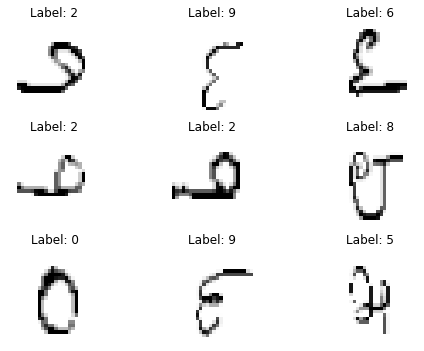

In [11]:
batch_show(trainset, labels, n_images=9)

### Data preprocessing

In [12]:
# reshaping 2D ndarrays into 4D (#images, #channel, #width, #height)
# converting datasets into tensors
trainset = torch.tensor(np.reshape(trainset, (trainset.shape[0], 1, 28, 28)))
labels = torch.tensor(labels)
testset = torch.tensor(np.reshape(testset, (testset.shape[0], 1, 28, 28)))
trainset.shape

torch.Size([60000, 1, 28, 28])

In [13]:
# Normalize pixel values
trainset /= 255
testset /= 255

In [14]:
class Dataset(data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img, target = self.images[index], int(self.labels[index])
        return img, target

In [15]:
bs = 64

trainset = Dataset(trainset, labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

### Designing the Neural Network

In [34]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolution layer sees (28x28x1 tensor)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), padding=1)
        # Convolution layer sees (14x14x16 tensor)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1)        
        self.pool = nn.MaxPool2d(2,2)
        # dense layer after last conv and pooling layer
        self.fc1 = nn.Linear(in_features= 7*7*32, out_features=256)
        # output layer
        self.fc2 = nn.Linear(in_features=256, out_features=10)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten image input        
        x = x.view(-1, 7*7*32)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [35]:
model = Net()
model

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [36]:
images, lbls = next(iter(trainloader))

In [ ]:
output = model.forward(images)

In [39]:
images.dtype

torch.int64